In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

results_path = "/Users/matteo/Projects/MFI/results_plot"
path = "/Users/matteo/Projects/MFI"
os.chdir(path)

from pyMFI import MFI
from pyMFI import run_plumed

from matplotlib import rc
plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["computer modern roman"], "font.size": 22})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

times = r"$\times$"
pwr_neg = r"$^{-1}$"


# Figure1A: On the fly Error in 1D.

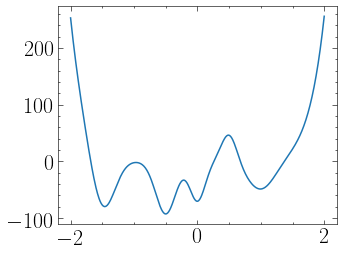

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from pyMFI import MFI1D
from pyMFI import run_plumed
import os


x=np.linspace(-2,2,500)
y=1*x**8-50*np.exp(-(x-1)**2/0.1)-93*np.exp(-(x+0.5)**2/0.05)-103*np.exp(-(x+1.5)**2/0.07)-70*np.exp(-(x)**2/0.03)+50*np.exp(-(x-0.5)**2/0.03)
plt.plot(x,y);


In [38]:
os.chdir("/Users/matteo/Projects/MFI_paper_figures/Figure1A")

#Run simulation
run_plumed.run_langevin1D(analytical_function = "1*x^8-50*exp(-(x-1)^2/0.1)-93*exp(-(x+0.5)^2/0.05)-103*exp(-(x+1.5)^2/0.07)-70*exp(-(x)^2/0.03)+50*exp(-(x-0.5)^2/0.03)", initial_position=-1.5, simulation_steps = 2000000 ,gaus_width=0.1, gaus_height=2.5, biasfactor=20, gaus_pace=100)

In [165]:
os.chdir("/Users/matteo/Projects/MFI_paper_figures/Figure1A")


#Read the HILLS file
HILLS=MFI1D.load_HILLS(hills_name="HILLS")

print(len(HILLS))

#Read the Colvar File
position = MFI1D.load_position(position_name="position")

#Compute the time-independent mean force
# [X, Ftot_den, Ftot, ofv, ofe, ofv_history, ofe_history, time_history, intermediate_fes_list, intermediate_time_list] = MFI1D.MFI_1D_cutoff(HILLS = HILLS, position = position, bw = 0.1, kT = 1, log_pace = 5, error_pace = 100, min_grid=-2.0, max_grid=2.0, WellTempered=1, intermediate_fes_number=100, truncation_limit=10**-5)
# [X, Ftot_den, Ftot, FES, ofv, ofe, ofv_history, ofe_history, time_history, intermediate_fes_list, intermediate_time_list] 

[X, Ftot_den, Ftot, FES, ofv, ofe, cutoff, ofv_history, ofe_history, time_history, intermediate_fes_list, intermediate_time_list] = MFI1D.MFI_1D(HILLS = HILLS, position = position, bw = 0.03, kT = 1, log_pace = 20, error_pace = 500, min_grid=-2.5, max_grid=2.5, WellTempered=1, intermediate_fes_number=100, truncation_limit=10**-8, FES_cutoff=1000)

# Integrate Ftot, obtain FES 
# FES = MFI1D.intg_1D(X,Ftot)
# Plot Recap
#MFI1D.plot_recap(X, MFI1D.zero_to_nan(FES*cutoff), MFI1D.zero_to_nan(Ftot_den*cutoff), MFI1D.zero_to_nan(ofe*cutoff), ofe_history, time_history, FES_lim=141, ofe_lim = 0, error_log_scale=0)

20000
-1
5.0%   OFE = 45.7377
10.0%   OFE = 31.4373
15.0%   OFE = 28.3633
20.0%   OFE = 27.4657
25.0%   OFE = 26.2986
30.0%   OFE = 26.0934
35.0%   OFE = 26.0261
40.0%   OFE = 25.7939
45.0%   OFE = 25.7489
50.0%   OFE = 25.3244
55.0%   OFE = 24.9097
60.0%   OFE = 25.1691
65.0%   OFE = 24.8575
70.0%   OFE = 24.762
75.0%   OFE = 24.8163
80.0%   OFE = 24.8299
85.0%   OFE = 24.7209
90.0%   OFE = 24.6907
95.0%   OFE = 32.4394
100.0%   OFE = 29.4835


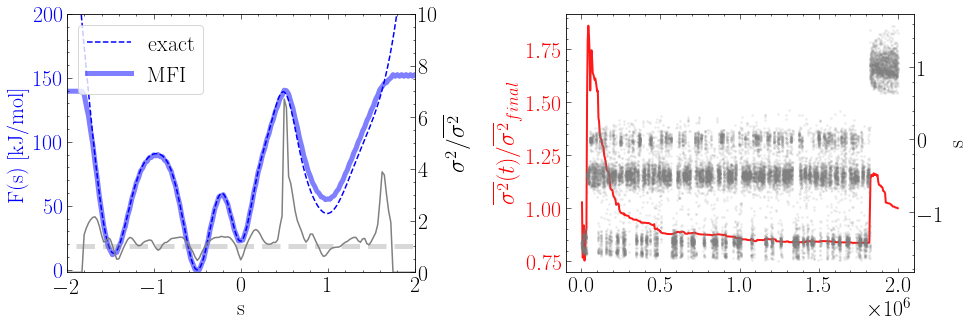

In [166]:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    
    #Left plot
    axs[0].set_ylabel('F(s) [kJ/mol]',color='blue')
    axs[0].set_xlabel('s')
    axs[0].set_xlim(-2,2)
    axs[0].set_ylim(-2,200)
    axs[0].plot(x, y-min(y),'--',color='blue',label='exact');
    axs[0].plot(X, FES,color='blue',linewidth=5,alpha=0.5,label="MFI");
    axs[0].tick_params(axis ='y', labelcolor = 'blue')
    
    ax1 = axs[0].twinx()
    ax1.set_ylabel('$\sigma^2/\overline{\sigma^2}$', fontsize=24, color='black')
    ax1.tick_params(axis ='y', labelcolor = 'black', right = True , labelright = True ) 
    ax1.set_ylim([0, 10] ) 
    ax1.plot(X, ofe/np.mean(ofe),color="grey",label="$\sigma^2(s)$");
    ax1.plot(X, np.zeros(len(X))+1,'--',linewidth=5,color="grey", alpha=0.3,label="$\overline{\sigma^2(s)}$");
    
    axs[0].legend()

    #Right plot
    ax2 = axs[1].twinx()
    
    axs[1].plot([time/0.005 for time in time_history], ofe_history/ofe_history[np.size(ofe_history)-1],color='red',linewidth=2,alpha=0.9);
    axs[1].set_ylabel('$\overline{\sigma^2}(t)/\overline{\sigma^2}_{final}$', fontsize=24, color='red')
    axs[1].tick_params(axis ='y', labelcolor = 'red')
    ax2.set_xlabel('Simulation steps')
    ax2.set_ylabel('s',color='black')
    ax2.tick_params(axis ='y', labelcolor = 'black')
    ax2.scatter(HILLS[:,0]/0.005,HILLS[:,1],color='grey',s=3, alpha=0.1)
    
    fig.tight_layout()    
    
    plt.savefig('Figure1A', dpi=600, bbox_inches='tight')
    